## Data Challenge 2: AB Testing

**This notebook is intended to explore data from an AB test of pricing for Company XYZ.**<br>
The company usually sells its software for \$39, but has initiated a 90-day test in which a third of the participants are randomly selected to pay \$59. The VP of marketing wants to know whether they should switch the price, how long they should've run the test, and any other relevant information that might help inform what the optimal price would be. <br><br>
I first load the data from two given csv files, then clean the data according to stated parameters for a sanity check (e.g., price should be completely determinable based on whether the person was in the test or control group). I perform several data analyses and visualizations, and finally list conclusions about this test and suggestions about finding the optimal price.<br><br>

### Step 1: Load the data

In [1]:
# First, import some modules that we'll be using later
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import chisquare
from datetime import datetime
from datetime import timedelta
from matplotlib import mlab
import math

In [2]:
# it's not a huge amount of data; I can simply import it all as two dataframes
user_table = pd.DataFrame.from_csv('/Users/z_home/zLearnPy/LeetCode_forGithub/Insight_DataChallenges/Data_Challenge2/user_table.csv')
test_results = pd.DataFrame.from_csv('/Users/z_home/zLearnPy/LeetCode_forGithub/Insight_DataChallenges/Data_Challenge2/test_results.csv')

In [3]:
# quick visualization to make sure we loaded what we think we did
print(user_table.iloc[100:115,:]) # just to confirm that it looks as expected
print(test_results.iloc[100:115,:]) 

                  city country    lat    long
user_id                                      
402771    North Bergen     USA  40.79  -74.03
722510        New York     USA  40.67  -73.94
830553        New York     USA  40.67  -73.94
558879     San Antonio     USA  29.46  -98.51
690980      Louisville     USA  38.22  -85.74
696028      Louisville     USA  38.22  -85.74
511675        New York     USA  40.67  -73.94
77463       Janesville     USA  42.68  -89.02
375184        New York     USA  40.67  -73.94
584486          Conway     USA  35.09  -92.45
521354          DeSoto     USA  32.60  -96.86
61526    Pinellas Park     USA  27.86  -82.71
254475       Milwaukee     USA  43.06  -87.97
582660      Portsmouth     USA  36.86  -76.36
965903     Chula Vista     USA  32.63 -117.04
                   timestamp           source  device operative_system  test  \
user_id                                                                        
538239   2015-03-28 08:21:13        ads-yahoo  mobile     

### Step 2: Clean the data

In [4]:
# First, sanity checks: we've been told some data should match.
test0_price59 = test_results.loc[(test_results.price == 59) & (test_results.test == 0)]
test1_price39 = test_results.loc[(test_results.price == 39) & (test_results.test == 1)]

print('test0_price59 = %s' % len(test0_price59)) # Should be zero, but isn't
print('test1_price39 = %s' % len(test1_price39)) # Should be zero, but isn't

test0_price59 = 210
test1_price39 = 155


In [5]:
# Exclude untrustworthy data (given it's just a quick analysis, no time to figure out which is correct)
test_results = test_results.loc[((test_results.price == 59) & (test_results.test == 1)) | 
                               ((test_results.price == 39) & (test_results.test == 0))] # ~350 of these

# There are also "times" that are nonsense (e.g., 60 in the minutes place); deal with these by just using the Date

In [6]:
# In order to figure out how long the test should have gone on, we will need to know when people converted. 
#    Probably just using the date is ok, at least for a first pass - the times are screwy in this dataset
test_results['date'] = pd.to_datetime(test_results['timestamp'].str[:10], format="%Y-%m-%d") 
print(min(test_results.date))
print(max(test_results.date))

2015-03-02 00:00:00
2015-05-31 00:00:00


In [7]:
# It would also be useful to look at the profit made rather than just the conversion binary
test_results['profit'] = test_results['price'] * test_results['converted']

print (test_results[10:14]) # just to see

                   timestamp           source  device operative_system  test  \
user_id                                                                        
590182   2015-04-17 13:30:04       ads-google     web          windows     0   
606479   2015-05-15 12:36:46   direct_traffic     web              mac     0   
425567   2015-04-24 10:09:04     ads_facebook     web          windows     0   
460593   2015-03-21 09:43:51  friend_referral  mobile              iOS     0   

         price  converted       date  profit  
user_id                                       
590182      39          0 2015-04-17       0  
606479      39          0 2015-05-15       0  
425567      39          0 2015-04-24       0  
460593      39          1 2015-03-21      39  


### Step 3: initial data exploration

In [8]:
# Now let's create some tables and figures to visualize these data
count_by_system = test_results.pivot_table(index='test', columns = 'operative_system', 
                    aggfunc={'profit':len})
profit_by_system = test_results.pivot_table(index='test', columns = 'operative_system', 
                    aggfunc={'profit':sum})
prof_per_person_system = profit_by_system.div(count_by_system)


print(count_by_system)
print(profit_by_system)
prof_per_person_system

                  profit                                   
operative_system android    iOS linux    mac  other windows
test                                                       
0                  48177  61793  2204  16345  10481   63517
1                  26693  33560  1926   8710   5696   37333
                  profit                                  
operative_system android    iOS linux    mac other windows
test                                                      
0                  30693  56862  1326  16224  5733   46332
1                  19470  39589     0  10915  3717   30857


profit                                                  
operative_system   android       iOS     linux       mac     other   windows
test                                                                        
0                 0.637088  0.920201  0.601633  0.992597  0.546990  0.729443
1                 0.729405  1.179648  0.000000  1.253157  0.652563  0.826534

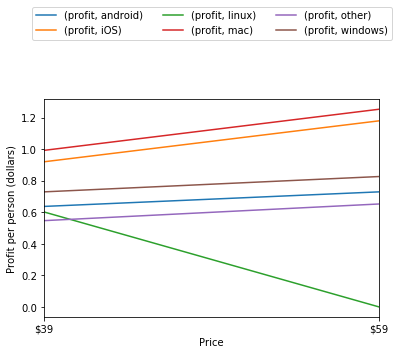

In [9]:
# And graphically - let's see where the profit is coming from, in terms of system
plt.clf()
prof_per_person_system.plot()
plt.ylabel("Profit per person (dollars)")
plt.xlabel("Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fancybox=True)
plt.xticks([0,1],['\$39','\$59'])

plt.show()

We'd like to know whether our overall profits per person are better at the \$59 than in the \$39 price. Here we can see that for most systems this is true, but for Linux users in particular it drops off completely at the new price, even though we have a comparable number of linux users arriving as at the \$39 price. This may indicate that these users are particularly sensitive to price.

          profit                                                             \
source  ads-bing ads-google ads-yahoo ads_facebook ads_other direct_traffic   
test                                                                          
0       0.521462   0.880063  0.656484     0.922522  0.601527       0.526891   
1       0.565175   1.158208  0.662921     0.994502  0.731220       0.596568   

                                                                              
source friend_referral  seo-bing seo-google seo-other seo-yahoo seo_facebook  
test                                                                          
0             1.625867  1.173815   0.682397  0.683279  0.761019     0.680856  
1             1.975255  0.796319   0.944293  0.736404  0.617304     0.802253  


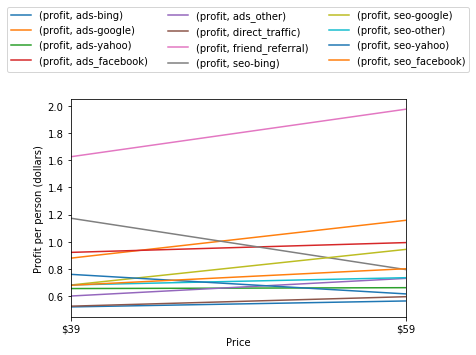

In [10]:
# Let's similarly visualize by source and by device
count_by_source = test_results.pivot_table(index='test', columns = 'source', 
                    aggfunc={'profit':len})
profit_by_source = test_results.pivot_table(index='test', columns = 'source', 
                    aggfunc={'profit':sum})
prof_per_person_source = profit_by_source.div(count_by_source)

print(prof_per_person_source)

plt.clf()
prof_per_person_source.plot()
plt.ylabel("Profit per person (dollars)")
plt.xlabel("Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fancybox=True)
plt.xticks([0,1],['\$39','\$59'])

plt.show()



Here we can see that the profit has really increased from friend referrals - we're doing something right there, at the new price. It's dropped off sharply for people coming in through SEO-Yahoo and SEO-Bing; perhaps these people are more price sensitive? Or perhaps there's an opportunity here (e.g., we may still be advertising the old price on these services).

          profit          
device    mobile       web
test                      
0       0.775017  0.777645
1       0.952624  0.869888


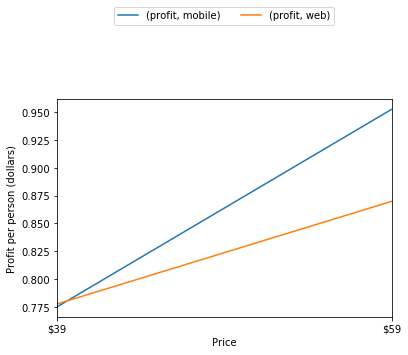

In [11]:
# Visualizing by device
count_by_device = test_results.pivot_table(index='test', columns = 'device', 
                    aggfunc={'profit':len})
profit_by_device = test_results.pivot_table(index='test', columns = 'device', 
                    aggfunc={'profit':sum})
prof_per_person_device = profit_by_device.div(count_by_device)

print(prof_per_person_device)

plt.clf()
prof_per_person_device.plot()
plt.ylabel("Profit per person (dollars)")
plt.xlabel("Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2, fancybox=True)
plt.xticks([0,1],['\$39','\$59'])

plt.show()




The device breakdown doesn't appear particularly meaningful, though we are getting a lot more of our profits from mobile sales at the new price than we were at the old.

### Step 4: Answer the questions
We were asked two specific questions:
1. Which of these two price points is better?
2. Did the test go on for too long? And if so, when could we have stopped it?

39 202517 0.0198995639872 0.139655187302
59 113918 0.0155550483681 0.123746065951


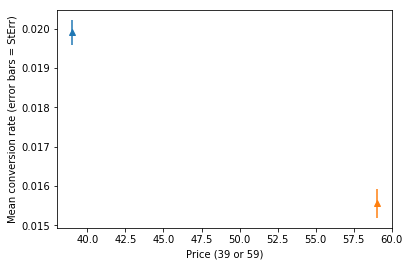

In [13]:
# What are the mean conversion rates, by price(=test)?
plt.clf()
prices = [''] # first tick is at zero, so make that one blank
means = []
stdErrs = []
for price in test_results.price.unique():
    prices.append(price)
    price_rows = test_results.loc[test_results['price']==price]
    means.append(np.mean(price_rows['converted']))
    stdErrs.append((np.std(price_rows['converted'])) / np.sqrt(len(price_rows)))
    print(price, len(price_rows), np.mean(price_rows['converted']), 
          np.std(price_rows['converted']))
    plt.errorbar(price, np.mean(price_rows['converted']), 
                 (np.std(price_rows['converted'])) / np.sqrt(len(price_rows)), linestyle='None', marker='^')
    
plt.ylabel('Mean conversion rate (error bars = StErr)')
plt.xlabel('Price (39 or 59)')
                  
plt.show()

In [14]:
# Std Err doesn't really apply here, since we don't have a normal distribution (really), but with so many datapoints
#    I imagine the central limit theorem kicks in. Still, we should probably check (with a non-parametric test?).
price39 = test_results.loc[test_results['price']==39]
price59 = test_results.loc[test_results['price']==59]

t_test = stats.ttest_ind(price39['converted'], price59['converted'], axis=0, equal_var=True, nan_policy='propagate')
rank_sum = stats.ranksums(price39['converted'], price59['converted'])
print(t_test)
print(rank_sum)

Ttest_indResult(statistic=8.744781828681587, pvalue=2.2450851601497147e-18)
RanksumsResult(statistic=2.0318234376849711, pvalue=0.042171533571227014)


That's a huge difference between the parametric and non-parametric p-values; this is reasonable, since the rank-sum only has three ranks to deal with (0, 39, 59). Still, if even that shows a significant difference (at alpha = .05), we can be quite confident it's a real difference. 

In [15]:
# Given that more people convert at a lower price (expected), we'll have to do some math to see which is the best price

# For every 1 person that visited the site, 0.019899563987220825 people bought at $39; so, profit per person = 
rows_39 = test_results.loc[test_results.price == 39]
print("Profit per person in the 39 group = %s" % (39 * np.mean(rows_39.converted))) # 0.776 = profit per person

# For every 1 person that visited the site, 0.01555504836812444 people bought at $59
rows_59 = test_results.loc[test_results.price == 59]
print("Profit per person in the 59 group = %s" % (59 * np.mean(rows_59.converted))) # 0.918 = profit per person

# If we want to know whether the new price is profitable, we need to have a hypothesis test that the profit is equal


Profit per person in the 39 group = 0.776082995502
Profit per person in the 59 group = 0.917747853719


In [16]:
def t_test_duration(inputs_39, inputs_59, print_vals):
    profits_39 = [x * 39 for x in inputs_39]
    profits_59 = [x * 59 for x in inputs_59]
    p_val = stats.ttest_ind(profits_39, profits_59, axis=0, equal_var=True, nan_policy='propagate')
    if (print_vals == True):
        print(p_val)
    
    return p_val

In [17]:
# Let's see at what point the test could have been stopped with statistically significant results
test_results = test_results.sort_values(by='date')
start_date = min(test_results.date)

results_table = pd.DataFrame(index=[], columns=['days', 'means39', 'means59', 'stdevs39', 'stdevs59', 'pvals'])

for uq_date in test_results.date.unique():
    rows_in_range = test_results[test_results.date <= uq_date]
    in_range_39 = rows_in_range.loc[rows_in_range.price == 39]
    in_range_59 = rows_in_range.loc[rows_in_range.price == 59]
    
    date = rows_in_range['date'].iloc[-1] # completely insane that I can't get this from uq_date, which is a datetime64 for some stupid reason

    days = date - start_date
    p_val = t_test_duration(in_range_39['profit'], in_range_59['profit'], False)
    results_table = pd.concat([results_table, 
                               pd.DataFrame({'days': [days], 'means39': [np.mean(in_range_39['profit'])], 
                                             'means59': [np.mean(in_range_59['profit'])],
                                             'stdevs39': [np.std(in_range_39['profit'])], 
                                             'stdevs59': [np.std(in_range_59['profit'])], 'pvals': [p_val[1]]})])
print(results_table[:10])

# Though note we'll have to use a Bonferroni or some other correction for multiple tests


    days   means39   means59         pvals  stdevs39  stdevs59
0 0 days  0.694362  0.918685  8.900784e-02  5.157323  7.304686
0 1 days  0.788491  0.765571  1.885445e-01  5.489030  6.677019
0 2 days  0.906977  0.766234  2.901827e-01  5.877881  6.679871
0 3 days  0.948354  0.996622  6.377728e-03  6.007198  7.603119
0 4 days  0.834901  0.986697  3.766467e-06  5.644828  7.565815
0 5 days  0.829723  1.041978  1.217158e-09  5.627676  7.771164
0 6 days  0.825489  1.025122  5.111421e-11  5.613613  7.709170
0 7 days  0.832539  1.030649  1.454277e-11  5.637013  7.729555
0 8 days  0.832337  1.016738  1.196656e-11  5.636344  7.678136
0 9 days  0.822296  1.020800  1.129813e-12  5.602977  7.693189


In [18]:
# Let's do the actual calculation about when to stop, for alpha values of .05 and .01
finished_calc = pd.DataFrame(index=[], columns=['day'])
finished_calc['day'] = results_table['days'].dt.days

finished_calc['one_tailed_pvals'] = results_table['pvals'] / 2 # assume we knew the higher price would be better
finished_calc['bonf_05'] = .05
finished_calc['bonf_05'] = finished_calc['bonf_05'] / (finished_calc['day'] + 1)
finished_calc['alpha_05'] = np.where((finished_calc['one_tailed_pvals'] < 
                                      finished_calc['bonf_05']), True, False)
finished_calc['bonf_01'] = .01
finished_calc['bonf_01'] = finished_calc['bonf_01'] / (finished_calc['day'] + 1)
finished_calc['alpha_01'] = np.where((finished_calc['one_tailed_pvals'] < 
                                      finished_calc['bonf_01']), True, False)


print(finished_calc[:10])

   day  one_tailed_pvals   bonf_05  alpha_05   bonf_01  alpha_01
0    0      4.450392e-02  0.050000      True  0.010000     False
0    1      9.427227e-02  0.025000     False  0.005000     False
0    2      1.450913e-01  0.016667     False  0.003333     False
0    3      3.188864e-03  0.012500      True  0.002500     False
0    4      1.883233e-06  0.010000      True  0.002000      True
0    5      6.085789e-10  0.008333      True  0.001667      True
0    6      2.555711e-11  0.007143      True  0.001429      True
0    7      7.271384e-12  0.006250      True  0.001250      True
0    8      5.983282e-12  0.005556      True  0.001111      True
0    9      5.649064e-13  0.005000      True  0.001000      True


This suggests that we could have stopped the test after less than a week and been confident that the new price was better. However, this assumes that the distribution of the prices is Gaussian, which it certainly is not. We could do a nonparmateric test (e.g., Wilcoxin R-S), but we don't have the power. Thus, a chi-squared test (comparing the proportions) would likely be preferable.

In [19]:
# We should also ensure this was a fair test - means for various subgroups should be similar
#    Though note: we've already done most of this in our IDE (Step 3)

test_results_39 = test_results[test_results['price'] == 39]

subgroups_39 = pd.DataFrame(index=[], columns=['source'])

subgroups_39['source'] = test_results_39['source']
subgroups_39['profit'] = test_results_39['profit']
subgroups_39['prof_ads-g'] = test_results_39['source'].map(lambda x: x == 'ads-google')
subgroups_39['prof_ads-g'] = subgroups_39['prof_ads-g'] * subgroups_39['profit']
subgroups_39['prof_ads-f'] = test_results_39['source'].map(lambda x: x == 'ads_facebook')
subgroups_39['prof_ads-f'] = subgroups_39['prof_ads-f'] * subgroups_39['profit']
subgroups_39['prof_ads-b'] = test_results_39['source'].map(lambda x: x == 'ads-bing')
subgroups_39['prof_ads-b'] = subgroups_39['prof_ads-b'] * subgroups_39['profit']
subgroups_39['prof_ads-y'] = test_results_39['source'].map(lambda x: x == 'ads-yahoo')
subgroups_39['prof_ads-y'] = subgroups_39['prof_ads-y'] * subgroups_39['profit']
subgroups_39['prof_ads-o'] = test_results_39['source'].map(lambda x: x == 'ads_other')
subgroups_39['prof_ads-o'] = subgroups_39['prof_ads-o'] * subgroups_39['profit']

subgroups_39['prof_seo-g'] = test_results_39['source'].map(lambda x: x == 'seo-google')
subgroups_39['prof_seo-g'] = subgroups_39['prof_seo-g'] * subgroups_39['profit']
subgroups_39['prof_seo-f'] = test_results_39['source'].map(lambda x: x == 'seo_facebook')
subgroups_39['prof_seo-f'] = subgroups_39['prof_seo-f'] * subgroups_39['profit']
subgroups_39['prof_seo-b'] = test_results_39['source'].map(lambda x: x == 'seo-bing')
subgroups_39['prof_seo-b'] = subgroups_39['prof_seo-b'] * subgroups_39['profit']
subgroups_39['prof_seo-y'] = test_results_39['source'].map(lambda x: x == 'seo-yahoo')
subgroups_39['prof_seo-y'] = subgroups_39['prof_seo-y'] * subgroups_39['profit']
subgroups_39['prof_seo-o'] = test_results_39['source'].map(lambda x: x == 'seo-other')
subgroups_39['prof_seo-o'] = subgroups_39['prof_seo-o'] * subgroups_39['profit']

subgroups_39['prof_direct'] = test_results_39['source'].map(lambda x: x == 'direct_traffic')
subgroups_39['prof_direct'] = subgroups_39['prof_direct'] * subgroups_39['profit']
subgroups_39['prof_friend'] = test_results_39['source'].map(lambda x: x == 'friend_referral')
subgroups_39['prof_friend'] = subgroups_39['prof_friend'] * subgroups_39['profit']





test_results_59 = test_results[test_results['price'] == 59]

subgroups_59 = pd.DataFrame(index=[], columns=['source'])

subgroups_59['source'] = test_results_59['source']
subgroups_59['profit'] = test_results_59['profit']
subgroups_59['prof_ads-g'] = test_results_59['source'].map(lambda x: x == 'ads-google')
subgroups_59['prof_ads-g'] = subgroups_59['prof_ads-g'] * subgroups_59['profit']
subgroups_59['prof_ads-f'] = test_results_59['source'].map(lambda x: x == 'ads_facebook')
subgroups_59['prof_ads-f'] = subgroups_59['prof_ads-f'] * subgroups_59['profit']
subgroups_59['prof_ads-b'] = test_results_59['source'].map(lambda x: x == 'ads-bing')
subgroups_59['prof_ads-b'] = subgroups_59['prof_ads-b'] * subgroups_59['profit']
subgroups_59['prof_ads-y'] = test_results_59['source'].map(lambda x: x == 'ads-yahoo')
subgroups_59['prof_ads-y'] = subgroups_59['prof_ads-y'] * subgroups_59['profit']
subgroups_59['prof_ads-o'] = test_results_59['source'].map(lambda x: x == 'ads_other')
subgroups_59['prof_ads-o'] = subgroups_59['prof_ads-o'] * subgroups_59['profit']

subgroups_59['prof_seo-g'] = test_results_59['source'].map(lambda x: x == 'seo-google')
subgroups_59['prof_seo-g'] = subgroups_59['prof_seo-g'] * subgroups_59['profit']
subgroups_59['prof_seo-f'] = test_results_59['source'].map(lambda x: x == 'seo_facebook')
subgroups_59['prof_seo-f'] = subgroups_59['prof_seo-f'] * subgroups_59['profit']
subgroups_59['prof_seo-b'] = test_results_59['source'].map(lambda x: x == 'seo-bing')
subgroups_59['prof_seo-b'] = subgroups_59['prof_seo-b'] * subgroups_59['profit']
subgroups_59['prof_seo-y'] = test_results_59['source'].map(lambda x: x == 'seo-yahoo')
subgroups_59['prof_seo-y'] = subgroups_59['prof_seo-y'] * subgroups_59['profit']
subgroups_59['prof_seo-o'] = test_results_59['source'].map(lambda x: x == 'seo-other')
subgroups_59['prof_seo-o'] = subgroups_59['prof_seo-o'] * subgroups_59['profit']

subgroups_59['prof_direct'] = test_results_59['source'].map(lambda x: x == 'direct_traffic')
subgroups_59['prof_direct'] = subgroups_59['prof_direct'] * subgroups_59['profit']
subgroups_59['prof_friend'] = test_results_59['source'].map(lambda x: x == 'friend_referral')
subgroups_59['prof_friend'] = subgroups_59['prof_friend'] * subgroups_59['profit']



print('Price 39: mean profit from google ads: %s' % np.mean(subgroups_39['prof_ads-g']))
print('Price 39: mean profit from facebook ads: %s' % np.mean(subgroups_39['prof_ads-f']))
print('Price 39: mean profit from yahoo ads: %s' % np.mean(subgroups_39['prof_ads-y']))
print('Price 39: mean profit from bing ads: %s' % np.mean(subgroups_39['prof_ads-b']))
print('Price 39: mean profit from other ads: %s' % np.mean(subgroups_39['prof_ads-o']))

print('Price 39: mean profit from google seo: %s' % np.mean(subgroups_39['prof_seo-g']))
print('Price 39: mean profit from facebook seo: %s' % np.mean(subgroups_39['prof_seo-f']))
print('Price 39: mean profit from yahoo seo: %s' % np.mean(subgroups_39['prof_seo-y']))
print('Price 39: mean profit from bing seo: %s' % np.mean(subgroups_39['prof_seo-b']))
print('Price 39: mean profit from other seo: %s' % np.mean(subgroups_39['prof_seo-o']))

print('Price 39: mean profit from direct traffic: %s' % np.mean(subgroups_39['prof_direct']))
print('Price 39: mean profit from friend referral: %s' % np.mean(subgroups_39['prof_friend']))

print('') # line break

print('Price 59: mean profit from google ads: %s' % np.mean(subgroups_59['prof_ads-g']))
print('Price 59: mean profit from facebook ads: %s' % np.mean(subgroups_59['prof_ads-f']))
print('Price 59: mean profit from yahoo ads: %s' % np.mean(subgroups_59['prof_ads-y']))
print('Price 59: mean profit from bing ads: %s' % np.mean(subgroups_59['prof_ads-b']))
print('Price 59: mean profit from other ads: %s' % np.mean(subgroups_59['prof_ads-o']))

print('Price 59: mean profit from google seo: %s' % np.mean(subgroups_59['prof_seo-g']))
print('Price 59: mean profit from facebook seo: %s' % np.mean(subgroups_59['prof_seo-f']))
print('Price 59: mean profit from yahoo seo: %s' % np.mean(subgroups_59['prof_seo-y']))
print('Price 59: mean profit from bing seo: %s' % np.mean(subgroups_59['prof_seo-b']))
print('Price 59: mean profit from other seo: %s' % np.mean(subgroups_59['prof_seo-o']))

print('Price 59: mean profit from direct traffic: %s' % np.mean(subgroups_59['prof_direct']))
print('Price 59: mean profit from friend referral: %s' % np.mean(subgroups_59['prof_friend']))


Price 39: mean profit from google ads: 0.164460267533
Price 39: mean profit from facebook ads: 0.1552165991
Price 39: mean profit from yahoo ads: 0.0155986904803
Price 39: mean profit from bing ads: 0.0375524030081
Price 39: mean profit from other ads: 0.0571951984278
Price 39: mean profit from google seo: 0.0508401763803
Price 39: mean profit from facebook seo: 0.0452554600355
Price 39: mean profit from yahoo seo: 0.016368996183
Price 39: mean profit from bing seo: 0.00770305702731
Price 39: mean profit from other seo: 0.0198353718453
Price 39: mean profit from direct traffic: 0.100717470632
Price 39: mean profit from friend referral: 0.105339304848

Price 59: mean profit from google ads: 0.218560719114
Price 59: mean profit from facebook ads: 0.168322828701
Price 59: mean profit from yahoo ads: 0.0160554082761
Price 59: mean profit from bing ads: 0.0409153952843
Price 59: mean profit from other ads: 0.0678470478765
Price 59: mean profit from google seo: 0.0668112150845
Price 59: mean

In [20]:
# Anything interesting in the breakdown from device or OS?

test_results_39 = test_results[test_results['price'] == 39]

subgroups_39 = pd.DataFrame(index=[], columns=['source'])

subgroups_39['source'] = test_results_39['source']
subgroups_39['profit'] = test_results_39['profit']
subgroups_39['prof_mobile'] = test_results_39['device'].map(lambda x: x == 'mobile')
subgroups_39['prof_mobile'] = subgroups_39['prof_mobile'] * subgroups_39['profit']
subgroups_39['prof_web'] = test_results_39['device'].map(lambda x: x == 'web')
subgroups_39['prof_web'] = subgroups_39['prof_web'] * subgroups_39['profit']

subgroups_39['prof_win'] = test_results_39['operative_system'].map(lambda x: x == 'windows')
subgroups_39['prof_win'] = subgroups_39['prof_win'] * subgroups_39['profit']
subgroups_39['prof_linux'] = test_results_39['operative_system'].map(lambda x: x == 'linux')
subgroups_39['prof_linux'] = subgroups_39['prof_linux'] * subgroups_39['profit']
subgroups_39['prof_mac'] = test_results_39['operative_system'].map(lambda x: x == 'mac')
subgroups_39['prof_mac'] = subgroups_39['prof_mac'] * subgroups_39['profit']
subgroups_39['prof_iOS'] = test_results_39['operative_system'].map(lambda x: x == 'iOS')
subgroups_39['prof_iOS'] = subgroups_39['prof_iOS'] * subgroups_39['profit']
subgroups_39['prof_android'] = test_results_39['operative_system'].map(lambda x: x == 'android')
subgroups_39['prof_android'] = subgroups_39['prof_android'] * subgroups_39['profit']
subgroups_39['prof_other'] = test_results_39['operative_system'].map(lambda x: x == 'other')
subgroups_39['prof_other'] = subgroups_39['prof_other'] * subgroups_39['profit']


test_results_59 = test_results[test_results['price'] == 59]

subgroups_59 = pd.DataFrame(index=[], columns=['source'])

subgroups_59['source'] = test_results_59['source']
subgroups_59['profit'] = test_results_59['profit']

subgroups_59['prof_mobile'] = test_results_59['device'].map(lambda x: x == 'mobile')
subgroups_59['prof_mobile'] = subgroups_59['prof_mobile'] * subgroups_59['profit']
subgroups_59['prof_web'] = test_results_59['device'].map(lambda x: x == 'web')
subgroups_59['prof_web'] = subgroups_59['prof_web'] * subgroups_59['profit']

subgroups_59['prof_win'] = test_results_59['operative_system'].map(lambda x: x == 'windows')
subgroups_59['prof_win'] = subgroups_59['prof_win'] * subgroups_59['profit']
subgroups_59['prof_linux'] = test_results_59['operative_system'].map(lambda x: x == 'linux')
subgroups_59['prof_linux'] = subgroups_59['prof_linux'] * subgroups_59['profit']
subgroups_59['prof_mac'] = test_results_59['operative_system'].map(lambda x: x == 'mac')
subgroups_59['prof_mac'] = subgroups_59['prof_mac'] * subgroups_59['profit']
subgroups_59['prof_iOS'] = test_results_59['operative_system'].map(lambda x: x == 'iOS')
subgroups_59['prof_iOS'] = subgroups_59['prof_iOS'] * subgroups_59['profit']
subgroups_59['prof_android'] = test_results_59['operative_system'].map(lambda x: x == 'android')
subgroups_59['prof_android'] = subgroups_59['prof_android'] * subgroups_59['profit']
subgroups_59['prof_other'] = test_results_59['operative_system'].map(lambda x: x == 'other')
subgroups_59['prof_other'] = subgroups_59['prof_other'] * subgroups_59['profit']



print('Price 39: mean profit from mobile: %s' % np.mean(subgroups_39['prof_mobile']))
print('Price 39: mean profit from web: %s' % np.mean(subgroups_39['prof_web']))
print('Price 39: mean profit from windows: %s' % np.mean(subgroups_39['prof_win']))
print('Price 39: mean profit from linux: %s' % np.mean(subgroups_39['prof_linux']))
print('Price 39: mean profit from mac: %s' % np.mean(subgroups_39['prof_mac']))
print('Price 39: mean profit from iOS: %s' % np.mean(subgroups_39['prof_iOS']))
print('Price 39: mean profit from android: %s' % np.mean(subgroups_39['prof_android']))
print('Price 39: mean profit from other: %s' % np.mean(subgroups_39['prof_other']))

print('') # line break

print('Price 59: mean profit from mobile: %s' % np.mean(subgroups_59['prof_mobile']))
print('Price 59: mean profit from web: %s' % np.mean(subgroups_59['prof_web']))
print('Price 59: mean profit from windows: %s' % np.mean(subgroups_59['prof_win']))
print('Price 59: mean profit from linux: %s' % np.mean(subgroups_59['prof_linux']))
print('Price 59: mean profit from mac: %s' % np.mean(subgroups_59['prof_mac']))
print('Price 59: mean profit from iOS: %s' % np.mean(subgroups_59['prof_iOS']))
print('Price 59: mean profit from android: %s' % np.mean(subgroups_59['prof_android']))
print('Price 59: mean profit from other: %s' % np.mean(subgroups_59['prof_other']))




Price 39: mean profit from mobile: 0.460642810233
Price 39: mean profit from web: 0.315440185268
Price 39: mean profit from windows: 0.228780793711
Price 39: mean profit from linux: 0.00654759847321
Price 39: mean profit from mac: 0.080111793084
Price 39: mean profit from iOS: 0.280776428645
Price 39: mean profit from android: 0.151557647012
Price 39: mean profit from other: 0.0283087345754

Price 59: mean profit from mobile: 0.551063045348
Price 59: mean profit from web: 0.366684808371
Price 59: mean profit from windows: 0.27087027511
Price 59: mean profit from linux: 0.0
Price 59: mean profit from mac: 0.0958145332608
Price 59: mean profit from iOS: 0.347521901719
Price 59: mean profit from android: 0.170912410681
Price 59: mean profit from other: 0.0326287329483


### Step 5: Draw conclusions and make recommendations

# Conclusions
**1. Company XYZ should sell their product at \$59, not \$39.**<br>
While the conversion rate is lower at the higher price (around 1.6%, as opposed to around 2% for the lower price), the number of visitors that the site receives each day means that XYZ is making an average profit of 92 cents per visitor in the high-price group, compared to 78 cents per visitor with the original price.<br><br>
**2. The VP's intuition was correct: this test went on longer than it needed to.**<br>
Though these data are not at all normally distributed, the amount of data we have access to means that a parametric test like the t-test will probably give indicative results. If you use a t-test to determine whether the average profit per visitor is higher in the high-price group, you can tell within the first few days (depending on whether your alpha value is .05 or .01) that the profits are higher in the high-price group. Even with a strict correction method like Bonferroni, the high-price group comes out significantly more profitable within 5 days of testing.<br><br>
**3. Other observations / recommendations based on the data**<br>
A. Company XYZ had a dramatic drop in sales to Linux users when implementing the higher price. This group may be particularly sensitive to price, and thus perhaps a differential pricing structure could be considered based on operating system. However, the Linux users make up a very small percentage of overall sales, so this should be balanced against potential negative reactions from users of other systems.<br>
B. Profit from friend referrals has jumped substantially in the new pricing structure. If XYZ isn't yet incentivizing friend referrals, this would certainly be a place to increase profits.<br>
C. Profits have dropped from people coming in through SEO from Yahoo and Bing when implementing the higher price point. This is strange, since those users shouldn't look a whole lot different from Google users. Let's investigate whether the SEO we're using on these platforms is somehow targeting more price-sensitive users.<br>
D. When moving to this higher price point, our mobile sales are making up more and more of the total profits. We should focus our advertising on people using mobile devices.<br>
E. There were around 350 people whose "price" didn't match their "test" status (test / control group). If this was generated automatically, there may be a bug in that code - we should check to see what price they actually paid.
<br><br>





# Future work
**1. If we care about the location of these subjects:**<br>
We can check the geo-coordinates provided and make sure they match the cities that are listed. <br><br>
**2. We can also sanity-check the OS:**<br>
Theoretically, there are a set number of OSs depending on whether your device was "mobile" or "web". We could determine whether this was in fact the case, and look into erroneous data.